In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### generator

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh()  # Output is scaled to [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

### discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, x):
        return self.model(x)

### hyperparameters

In [7]:
lr = 1e-4
batch_size = 64
noise_dim = 100  # Dimension of the latent space (input to the generator)
img_dim = 28 * 28  # Image size (Fashion-MNIST is 28x28 pixels)
epochs = 50

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.2MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [9]:
generator = Generator(noise_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

criterion = nn.BCELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

In [10]:
for epoch in range(epochs):
    for real_images, _ in dataloader:
        
        real_images = real_images.view(-1, img_dim).to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f"Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

Epoch [1/50], d_loss: 0.1543, g_loss: 4.3284
Epoch [2/50], d_loss: 0.0471, g_loss: 5.4169
Epoch [3/50], d_loss: 0.5729, g_loss: 3.1524
Epoch [4/50], d_loss: 0.1510, g_loss: 7.8765
Epoch [5/50], d_loss: 0.0195, g_loss: 5.8887
Epoch [6/50], d_loss: 0.0968, g_loss: 7.1710
Epoch [7/50], d_loss: 0.0339, g_loss: 4.8897
Epoch [8/50], d_loss: 0.3334, g_loss: 4.3878
Epoch [9/50], d_loss: 0.2728, g_loss: 3.7147
Epoch [10/50], d_loss: 0.0824, g_loss: 4.8034
Epoch [11/50], d_loss: 0.1990, g_loss: 2.8167
Epoch [12/50], d_loss: 0.2208, g_loss: 2.9297
Epoch [13/50], d_loss: 0.1660, g_loss: 4.4185
Epoch [14/50], d_loss: 0.1189, g_loss: 5.3142
Epoch [15/50], d_loss: 0.6351, g_loss: 3.1622
Epoch [16/50], d_loss: 0.5582, g_loss: 3.3927
Epoch [17/50], d_loss: 0.6002, g_loss: 3.6001
Epoch [18/50], d_loss: 0.5446, g_loss: 2.9948
Epoch [19/50], d_loss: 0.4774, g_loss: 2.9368
Epoch [20/50], d_loss: 0.6012, g_loss: 3.4781
Epoch [21/50], d_loss: 0.3548, g_loss: 3.4999
Epoch [22/50], d_loss: 0.8272, g_loss: 3.66

### visualizing the fake images

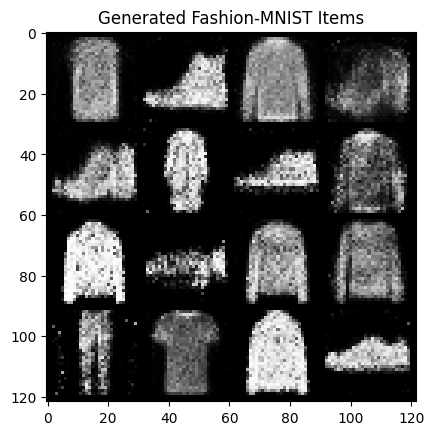

In [16]:
noise = torch.randn(16, noise_dim).to(device)
fake_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()

grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.title("Generated Fashion-MNIST Items")
plt.show()